# **Module 5: Spatial Interpolation in Python**
## **Prerequisites**
### Data
For this workshop, data are created and saved to the directory `./data-module-5/`.
- `meuse.csv` -  is a data set comprising of  heavy metals measured in the top soil in a flood plain along the river Meuse (exported from `R` package `sp`).
- `meuse_grid.csv` - regular grid covering the area of interest for interpolating Meuse observations.
### Software
To execute the code you will need a Python environment with the packages imported below.

**Environment Setup**
- `conda create --solver libmamba --clone user_default -p ~/envs/my_new_env`
- `conda activate ~/envs/my_new_env`
- `conda install --solver libmamba pyinterpolate`
- `python -m ipykernel install --user --name my_new_env --display-name "Python (my_new_env)"`

In [1]:
# general use packages
import os
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import math
import matplotlib.pyplot as plt

# geospatial packages
import geopandas as gpd
from shapely.geometry import MultiPoint
from shapely.ops import voronoi_diagram, triangulate
from pyinterpolate import inverse_distance_weighting, kriging
from pyinterpolate import build_experimental_variogram, build_theoretical_variogram, TheoreticalVariogram

os.environ['PROJ_LIB'] = '/opt/conda/envs/user_default/share/proj'

**`pyinterpolate` library documentation:**
- https://pyinterpolate.readthedocs.io/en/latest/index.html
- https://joss.theoj.org/papers/10.21105/joss.02869

## Read and vizualize input data

In [2]:
meuse_df = pd.read_csv("./data-module-5/meuse.csv", index_col=0)
print ("Dataset contains {} observations".format(len(meuse_df)))
meuse_df.head()

Dataset contains 155 observations


,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m
1,181072,333611,11.7,85,299,1022,7.909,0.001358,13.6,1,1,1,Ah,50
2,181025,333558,8.6,81,277,1141,6.983,0.012224,14.0,1,1,1,Ah,30
3,181165,333537,6.5,68,199,640,7.800,0.103029,13.0,1,1,1,Ah,150
4,181298,333484,2.6,81,116,257,7.655,0.190094,8.0,1,2,0,Ga,270
5,181307,333330,2.8,48,117,269,7.480,0.277090,8.7,1,2,0,Ah,380


<Axes: >

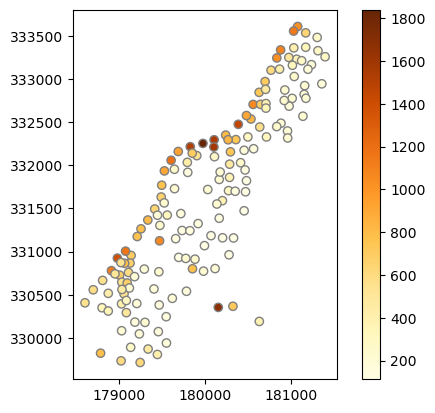

In [3]:
meuse_gdf = gpd.GeoDataFrame(meuse_df, geometry=gpd.points_from_xy(
    meuse_df.x, meuse_df.y), crs="epsg:28992")
meuse_gdf.plot(column="zinc", legend=True, cmap="YlOrBr", edgecolor="grey")

In [4]:
meuse_grid_df = pd.read_csv("./data-module-5/meuse-grid.csv", index_col = 0)
meuse_grid_df.head()

,x,y,part.a,part.b,dist,soil,ffreq
1,181180,333740,1,0,0.000000,1,1
2,181140,333700,1,0,0.000000,1,1
3,181180,333700,1,0,0.012224,1,1
4,181220,333700,1,0,0.043468,1,1
5,181100,333660,1,0,0.000000,1,1


<Axes: >

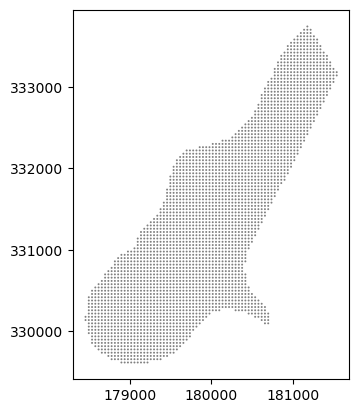

In [5]:
meuse_grid_gdf = gpd.GeoDataFrame(meuse_grid_df, geometry=gpd.points_from_xy(
    meuse_grid_df.x, meuse_grid_df.y), crs="epsg:28992")
meuse_grid_gdf.plot(markersize=2, facecolor="grey", edgecolor="none")

## Delaunay triangulation and Voronoi diagram

Before exploring spatial interpolation from point observations to a regular grid (or a surface), we start by illustrating techniques to partition space around points to create vector surfaces.

- **Delaunay triangulation** is a technique for creating nonoverlapping triangles from a dataset of points.
- **Voronoi diagram** is constructed around each sampled point so all the space within a specific polygon is closest in distance to that sampled point (as compared to other sampled points).

In [6]:
coordinates = MultiPoint(meuse_gdf["geometry"].tolist())

In [7]:
delaunay_geom  = triangulate(coordinates)
delaunay_gdf = gpd.GeoDataFrame(geometry=[geom for geom in delaunay_geom], crs="epsg:28992")

In [8]:
voronoi_geom = voronoi_diagram(coordinates)
voronoi_gdf = gpd.GeoDataFrame(geometry=[geom for geom in list(voronoi_geom.geoms)], crs="epsg:28992")

Text(0.5, 1.0, 'Voronoi diagram')

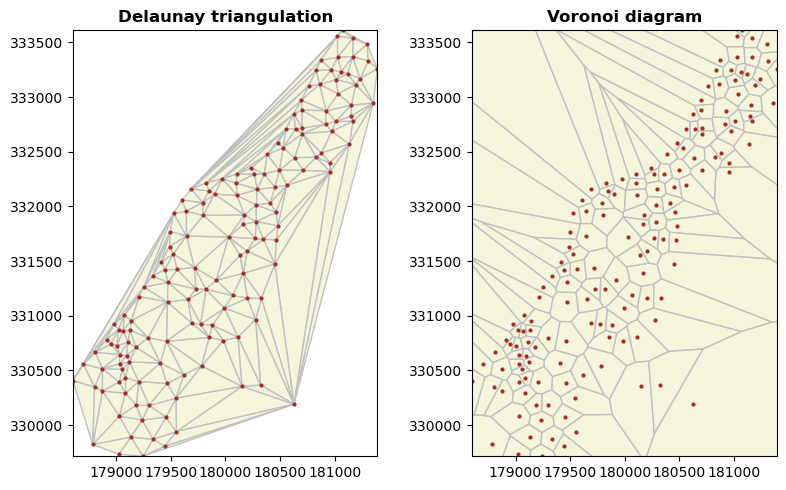

In [14]:
fig, axs = plt.subplots(1,2, figsize=(9, 5), tight_layout=True)

delaunay_gdf.plot(ax=axs[0], edgecolor="silver", color="beige")
meuse_gdf.plot(ax=axs[0], markersize=4, color="brown")
axs[0].set_xlim(meuse_gdf.total_bounds[0], meuse_gdf.total_bounds[2])
axs[0].set_ylim(meuse_gdf.total_bounds[1], meuse_gdf.total_bounds[3])
axs[0].set_title("Delaunay triangulation", weight="bold")

voronoi_gdf.plot(ax=axs[1], edgecolor="silver", color="beige")
meuse_gdf.plot(ax=axs[1], markersize=4, color="brown")
axs[1].set_xlim(meuse_gdf.total_bounds[0], meuse_gdf.total_bounds[2])
axs[1].set_ylim(meuse_gdf.total_bounds[1], meuse_gdf.total_bounds[3])
axs[1].set_title("Voronoi diagram", weight="bold")

## Inverse Distance Weighting (IDW)

IDW Parameters:
- **number of neighbours**: when using (-1), all known points will be used to estimate value at the unknown location.
- **power** controls weight assigned to each known point. Larger power means stronger influence of the closest neighbors, but it decreases quickly.


In [10]:
known_points = meuse_df[["x", "y", "zinc"]].to_numpy()

In [11]:
unknown_points = meuse_grid_df[["x", "y"]].to_numpy()

In [12]:
NUMBER_OF_NEIGHBOURS = -1
IDW_POWER = 0.25

idw_predictions = []
for pt in unknown_points:
    idw_result = inverse_distance_weighting(known_points, pt, NUMBER_OF_NEIGHBOURS,  IDW_POWER)
    idw_predictions.append(idw_result)

meuse_grid_gdf["zinc-pred-{}".format(IDW_POWER)] = idw_predictions

In [13]:
IDW_POWER = 2

idw_predictions = []
for pt in unknown_points:
    idw_result = inverse_distance_weighting(known_points, pt, NUMBER_OF_NEIGHBOURS,  IDW_POWER)
    idw_predictions.append(idw_result)

meuse_grid_gdf["zinc-pred-{}".format(IDW_POWER)] = idw_predictions

In [14]:
IDW_POWER = 16

idw_predictions = []
for pt in unknown_points:
    idw_result = inverse_distance_weighting(known_points, pt, NUMBER_OF_NEIGHBOURS,  IDW_POWER)
    idw_predictions.append(idw_result)

meuse_grid_gdf["zinc-pred-{}".format(IDW_POWER)] = idw_predictions

Text(0.5, 1.0, 'Power=16')

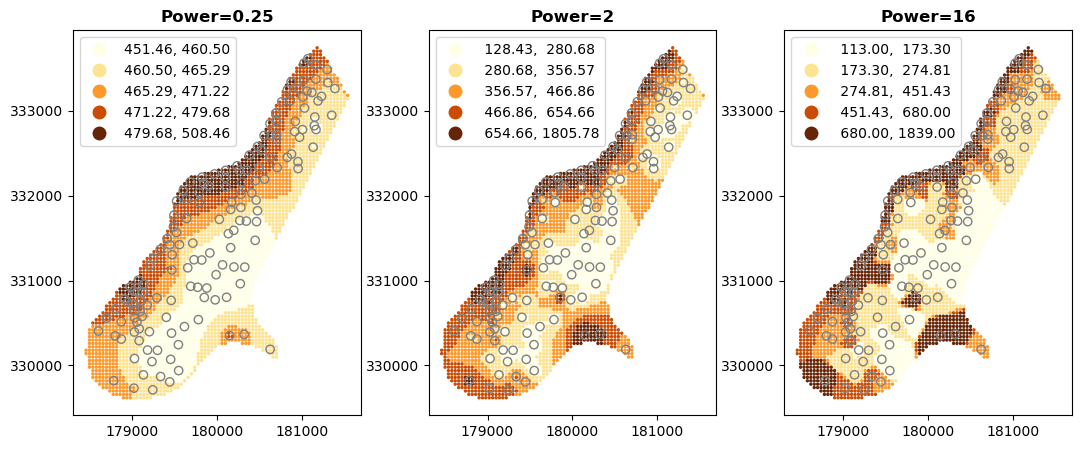

In [15]:
fig, axs = plt.subplots(1,3, figsize=(13,5))
meuse_grid_gdf.plot(ax=axs[0], column="zinc-pred-0.25", cmap="YlOrBr", scheme="JenksCaspall", legend=True, markersize=2)
meuse_gdf.plot(ax=axs[0], edgecolor="grey", facecolor="none")
axs[0].set_title("Power=0.25", weight="bold")
meuse_grid_gdf.plot(ax=axs[1], column="zinc-pred-2", cmap="YlOrBr", scheme="JenksCaspall", legend=True, markersize=2)
meuse_gdf.plot(ax=axs[1], edgecolor="grey", facecolor="none")
axs[1].set_title("Power=2", weight="bold")
meuse_grid_gdf.plot(ax=axs[2], column="zinc-pred-16", cmap="YlOrBr", scheme="JenksCaspall", legend=True, markersize=2)
meuse_gdf.plot(ax=axs[2], edgecolor="grey", facecolor="none")
axs[2].set_title("Power=16", weight="bold")

### Accuracy Assesment
**Here we split the "known" points into a training and a test sets to evaluate model performance on real observations.**

In [16]:
def create_model_validation_sets(dataset, training_set_ratio=0.5, rnd_seed=101):

    np.random.seed(rnd_seed)

    indexes_of_training_set = np.random.choice(range(len(dataset) - 1),
                                               int(training_set_ratio * len(dataset)),
                                               replace=False)
    training_set = dataset[indexes_of_training_set]
    test_set = np.delete(dataset, indexes_of_training_set, 0)
    return training_set, test_set

In [17]:
train, test = create_model_validation_sets(known_points)

In [18]:
NUMBER_OF_NEIGHBOURS = -1
IDW_POWERS = [0.25, 2, 16]
idw_rmse = {}
r2 = {}

for pw in IDW_POWERS:
    results = []
    for pt in test:
        idw_result = inverse_distance_weighting(train, pt[:-1], NUMBER_OF_NEIGHBOURS, pw)
        results.append(idw_result)
    idw_rmse[pw] = np.mean(np.sqrt((test[:, -1] - np.array(results))**2))
    r2[pw] = r2_score(test[:, -1].tolist(), results)

In [19]:
for pw in IDW_POWERS:
    print(f'Root Mean Squared Error of prediction with IDW of power {pw} is {idw_rmse[pw]:.2f}')
    print(f'R2 with IDW of power {pw} is {r2[pw]:.2f}')

Root Mean Squared Error of prediction with IDW of power 0.25 is 287.08
R2 with IDW of power 0.25 is 0.02
Root Mean Squared Error of prediction with IDW of power 2 is 217.04
R2 with IDW of power 2 is 0.37
Root Mean Squared Error of prediction with IDW of power 16 is 213.89
R2 with IDW of power 16 is 0.10


## Krigging

**Kriging** is a two-step process:
- It creates the variogram to estimate spatial autocorrelation. Variogram illustrates the dissimilarity between point pairs (y-axis) along a rising distance (x-axis).
- It predicts the unknown values.

#### Step 1: Build variogram

Experimental Variogram statistics:
- lag is a column with the lag center
- semivariance is a column with a dissimilarity metric
- covariance is a column with a similarity metric

<Axes: >

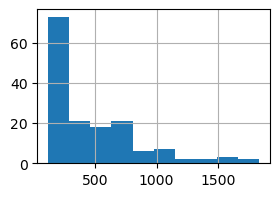

In [20]:
meuse_df["zinc"].hist(figsize=(3,2))

<Axes: >

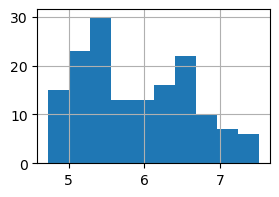

In [21]:
meuse_df["zinc-log"] = np.log(meuse_df["zinc"])
meuse_df["zinc-log"].hist(figsize=(3,2))

In [22]:
known_points =  meuse_df[["x", "y", "zinc-log"]].to_numpy()

+--------+---------------------+------------------------+---------------------+
|  lag   |     semivariance    |       covariance       |     var_cov_diff    |
+--------+---------------------+------------------------+---------------------+
| 100.0  | 0.12996593502348266 |  0.25850746787149276   | 0.25924277764643316 |
| 200.0  |  0.2091154470207987 |   0.266693033594785    |  0.2510572119231409 |
| 300.0  | 0.29516204566447485 |   0.1683647423631005   |  0.3493855031548254 |
| 400.0  |  0.383493805259452  |  0.09652485270379628   | 0.42122539281412963 |
| 500.0  |  0.4411669408840193 |  0.06276871120018505   | 0.45498153431774085 |
| 600.0  |  0.5212385600944631 |  0.006414504403525073  |  0.5113357411144008 |
| 700.0  |  0.5520223392768622 | -0.021829049586180885  |  0.5395792951041068 |
| 800.0  |  0.615367912380907  |  -0.06037828117066249  |  0.5781285266885884 |
| 900.0  |  0.6770043238130399 |  -0.09886025191589966  |  0.6166104974338256 |
| 1000.0 |  0.6439823873507268 |  -0.087

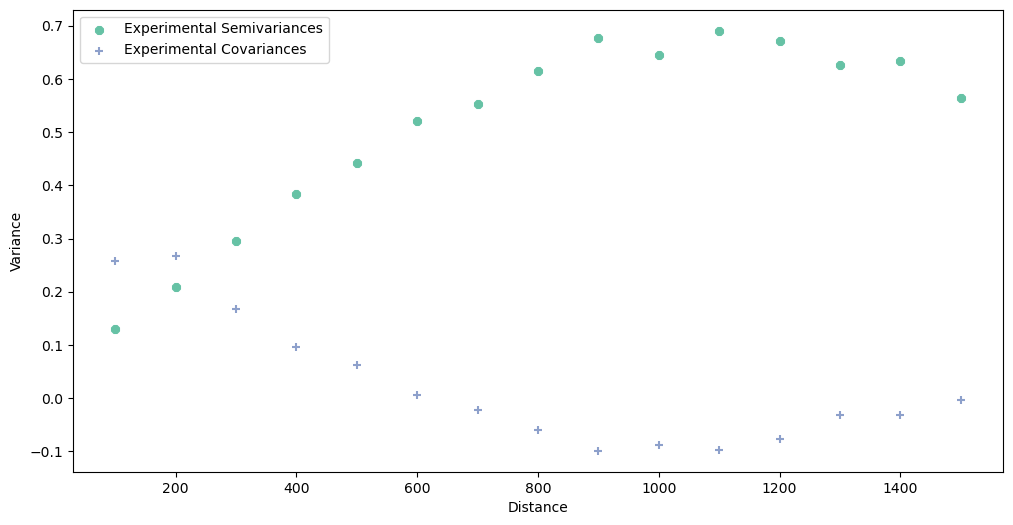

In [23]:
STEP_SIZE = 100
MAX_RANGE = 1600

exp_semivar = build_experimental_variogram(known_points, step_size=STEP_SIZE, max_range=MAX_RANGE)

print(exp_semivar)
exp_semivar.plot(plot_covariance=True)

* Selected model: Cubic model
* Nugget: 0.10397274801878614
* Sill: 0.5177502455179259
* Range: 1117.635831168235
* Spatial Dependency Strength is strong
* Mean Bias: nan
* Mean RMSE: 0.03278757593914768
* Error-lag weighting method: equal


+--------+---------------------+---------------------+------------------------+
|  lag   |     theoretical     |     experimental    |      bias (y-y')       |
+--------+---------------------+---------------------+------------------------+
| 100.0  | 0.12975270254169777 | 0.12996593502348266 | 0.0002132324817848974  |
| 200.0  |  0.1944009432403043 |  0.2091154470207987 |  0.014714503780494409  |
| 300.0  |  0.2799734600455819 | 0.29516204566447485 |  0.015188585618892969  |
| 400.0  |  0.370870504708611  |  0.383493805259452  |  0.012623300550840988  |
| 500.0  |  0.4547841009440864 |  0.4411669408840193 |  -0.01361716006006708  |
| 600.0  |  0.523376009653975  |  0.5212385600944631 | -0.0021374495595118947 |
| 700.0  |  0.5725963009247075 |  0.55

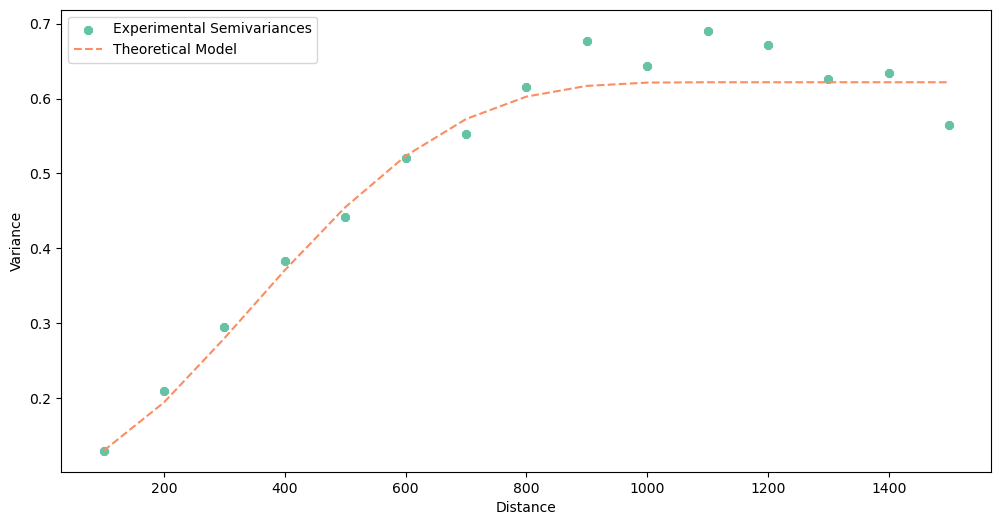

In [24]:
ALLOWED_MODELS = ['linear', 'circular', 'cubic', 'exponential', 'spherical']

theor_semivar = TheoreticalVariogram()
theor_semivar.autofit(experimental_variogram=exp_semivar,  model_types=ALLOWED_MODELS, max_nugget=0.8)

print (theor_semivar)
theor_semivar.plot()

#### Step 2: Make predictions

In [25]:
predictions = kriging(observations=known_points,
                      theoretical_model=theor_semivar,
                      points=unknown_points,
                      how="ok")

100%|██████████| 3103/3103 [00:01<00:00, 2771.19it/s]


In [26]:
meuse_grid_gdf["zinc-pred-ok-krigging"] = predictions[:, 0]
meuse_grid_gdf["varience-error-ok-krigging"] = predictions[:, 1]

Text(0.5, 1.0, 'Ordinary Krigging Variance Error')

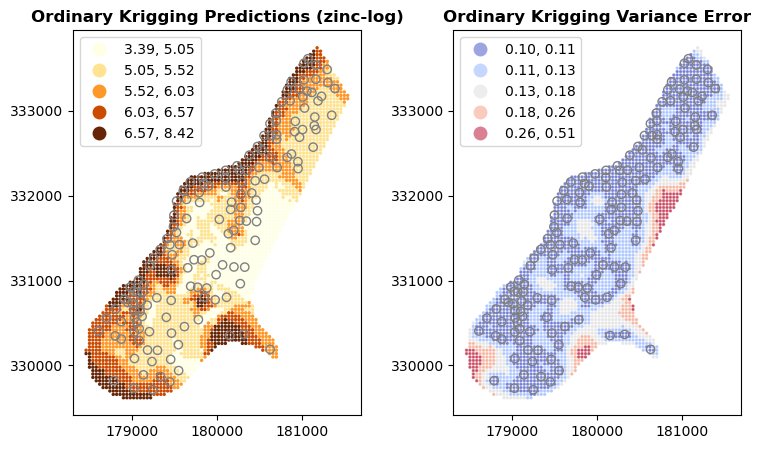

In [27]:
fig, axs = plt.subplots(1,2, figsize=(9,5))

meuse_grid_gdf.plot(ax=axs[0], column="zinc-pred-ok-krigging", cmap="YlOrBr",
                    scheme="JenksCaspall", legend=True, markersize=2)
meuse_gdf.plot(ax=axs[0], edgecolor="grey", facecolor="none")
axs[0].set_title("Ordinary Krigging Predictions (zinc-log)", weight="bold")

meuse_grid_gdf.plot(ax=axs[1], column="varience-error-ok-krigging", cmap="coolwarm",
                    scheme="JenksCaspall", legend=True, markersize=2, alpha=0.5)
meuse_gdf.plot(ax=axs[1], edgecolor="grey", facecolor="none")
axs[1].set_title("Ordinary Krigging Variance Error", weight="bold")

## Exercises
For the exercies, data are created and saved to the directory `./data-module-5/`.
- `mn-dem-points.shp` -  a dataset showing sampled DEM values for Minnesota based on USGS GMTED2010 dataset.
- `mn-grid.shp` -  regular grid covering the area of interest for interpolating Minnesota DEM observations.

**Question 1. Read the vector datasets `mn-dem-points.csv` and `mn-grid.shp` into a `GeoDataFrame`. Set CRS of for your point dataset the same as CRS of the grid shapefile**

In [28]:
grid = gpd.read_file("./data-module-5/mn-grid.shp")
print ("CRS of the unknown points is {}".format(grid.crs))

CRS of the unknown points is EPSG:26915


In [29]:
samples_df = pd.read_csv("./data-module-5/mn-dem-points.csv")
samples = gpd.GeoDataFrame(samples_df, geometry=gpd.points_from_xy(samples_df.X, samples_df.Y), crs=grid.crs)
print ("CRS of sampled points is {}".format(samples.crs))

CRS of sampled points is EPSG:26915


**Question 2. Plot the two datasets on the same `figure` object. How does Temperature vary spatially across the study area?**

<Axes: >

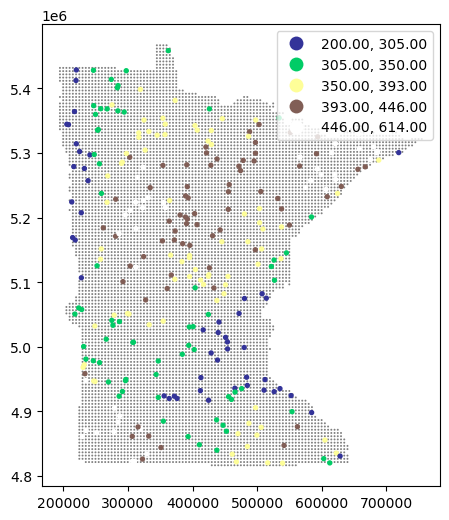

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
grid.plot(ax=ax, markersize=2, facecolor="grey", edgecolor="none")
samples.plot(ax=ax, column="DEM", cmap="terrain", legend=True, scheme="JenksCaspall", markersize=8)

**Question 3. Prepare `unknown_points` and `known_points` arrays from the datasets.**

In [31]:
unknown_points = grid[["x", "y"]].to_numpy()
known_points = samples[["X", "Y", "DEM"]].to_numpy()

**Question 4. Create an IDW surface predictions with different `power` parameter (`2` and `8`). Use `8` neighbous for both cases. Vizualize and compare the output (use continuous color scheme). What differences do you notice?**

In [32]:
NUMBER_OF_NEIGHBOURS = 8
IDW_POWER = 2

idw_predictions = []
for pt in unknown_points:
    idw_result = inverse_distance_weighting(known_points, pt, NUMBER_OF_NEIGHBOURS,  IDW_POWER)
    idw_predictions.append(idw_result)

grid["dem-pred-{}".format(IDW_POWER)] = idw_predictions

In [33]:
NUMBER_OF_NEIGHBOURS = 8
IDW_POWER = 8

idw_predictions = []
for pt in unknown_points:
    idw_result = inverse_distance_weighting(known_points, pt, NUMBER_OF_NEIGHBOURS,  IDW_POWER)
    idw_predictions.append(idw_result)

grid["dem-pred-{}".format(IDW_POWER)] = idw_predictions

Text(0.5, 1.0, 'Power=8')

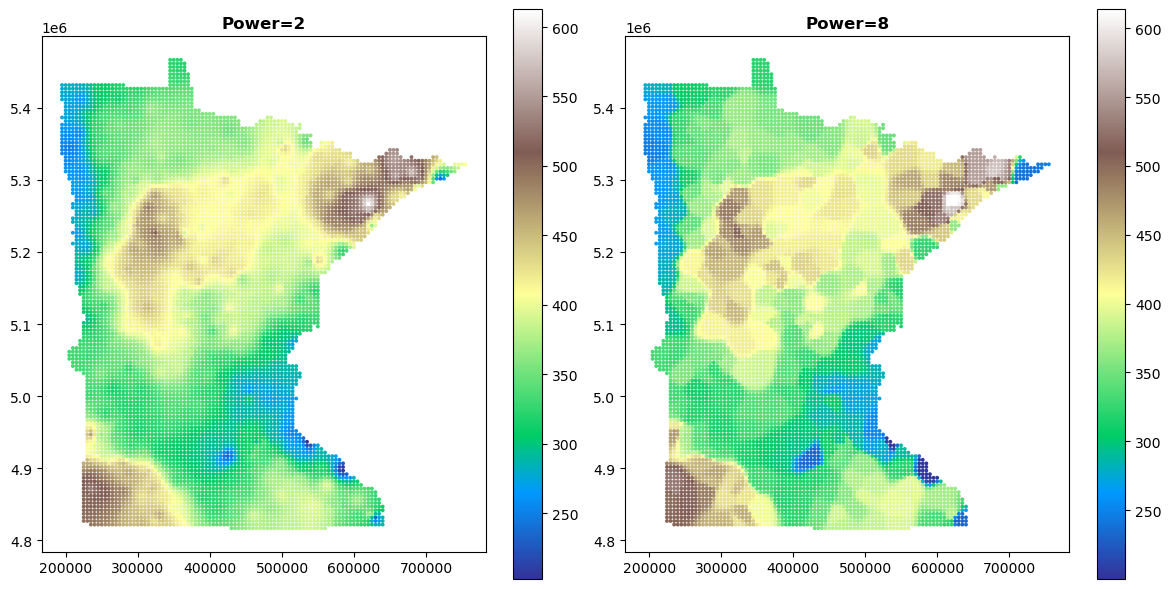

In [34]:
fig, axs = plt.subplots(1,2, figsize=(12,6), tight_layout=True)

grid.plot(ax=axs[0], column="dem-pred-2", cmap="terrain", legend=True, markersize=3)
axs[0].set_title("Power=2", weight="bold")

grid.plot(ax=axs[1], column="dem-pred-8", cmap="terrain", legend=True, markersize=3)
axs[1].set_title("Power=8", weight="bold")

**Question 5. Define a maximum range of spatial dependency for your variogram. This parameter should be at most half of the maximum distance between the known points.
Hint: use the function from: https://pyinterpolate.readthedocs.io/en/latest/api/distance/distance.html**

In [35]:
from pyinterpolate import calc_point_to_point_distance
distances = calc_point_to_point_distance(known_points)
print (np.max(distances) / 2)

361876.3656311927


**Question 6. Create an experimental variogram and then use `autofit.()` to produce a theoretical model.**

+----------+--------------------+---------------------+--------------------+
|   lag    |    semivariance    |      covariance     |    var_cov_diff    |
+----------+--------------------+---------------------+--------------------+
| 10000.0  | 451.40833333333336 |  4348.357708333365  | 366.9713916666351  |
| 20000.0  | 866.7317708333334  |  3221.4042358398438 | 1493.9248641601562 |
| 30000.0  | 1077.8529411764705 |  3659.436071596402  | 1055.8930284035978 |
| 40000.0  | 1864.2857142857142 |  2846.603167604518  | 1868.7259323954818 |
| 50000.0  | 1650.1042944785277 |  2511.3597258291725 | 2203.9693741708275 |
| 60000.0  | 1632.3580705009276 |  2213.6906419846064 | 2501.6384580153936 |
| 70000.0  | 2308.9321907600597 |  1754.4391153848774 | 2960.8899846151226 |
| 80000.0  | 2340.2304236200257 |  1784.6602021781703 |  2930.66889782183  |
| 90000.0  | 2386.4617314930993 |  1480.5323366010234 | 3234.7967633989765 |
| 100000.0 | 2832.3994219653177 |  1240.7078749707885 | 3474.6212250292115 |

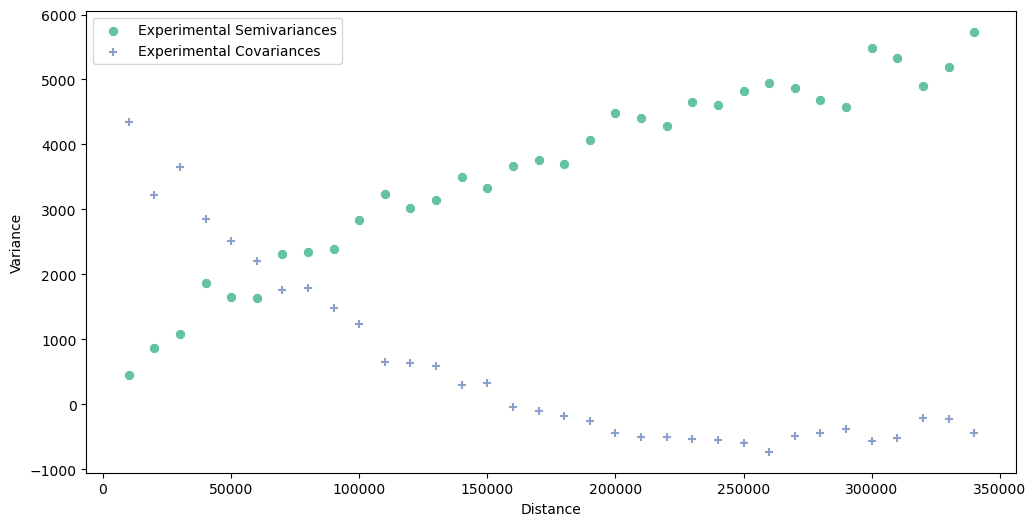

In [36]:
STEP_SIZE = 10000
MAX_RANGE = 350000

exp_semivar = build_experimental_variogram(known_points, step_size=STEP_SIZE, max_range=MAX_RANGE)
print(exp_semivar)
exp_semivar.plot(plot_covariance=True)

* Selected model: Spherical model
* Nugget: 225.70416666666668
* Sill: 4715.3291
* Range: 278604.9452143888
* Spatial Dependency Strength is strong
* Mean Bias: nan
* Mean RMSE: 288.2000478045969
* Error-lag weighting method: equal


+----------+--------------------+--------------------+---------------------+
|   lag    |    theoretical     |    experimental    |     bias (y-y')     |
+----------+--------------------+--------------------+---------------------+
| 10000.0  | 479.46693558995577 | 451.40833333333336 | -28.058602256622407 |
| 20000.0  | 732.5755703954446  | 866.7317708333334  |  134.15620043788874 |
| 30000.0  | 984.3759369653332  | 1077.8529411764705 |  93.47700421113734  |
| 40000.0  | 1234.2139011818206 | 1864.2857142857142 |  630.0718131038936  |
| 50000.0  | 1481.4353289271073 | 1650.1042944785277 |  168.66896555142034 |
| 60000.0  | 1725.3860860833927 | 1632.3580705009276 |  -93.02801558246506 |
| 70000.0  | 1965.4120385328765 | 2308.9321907600597 |  343.5201522271832

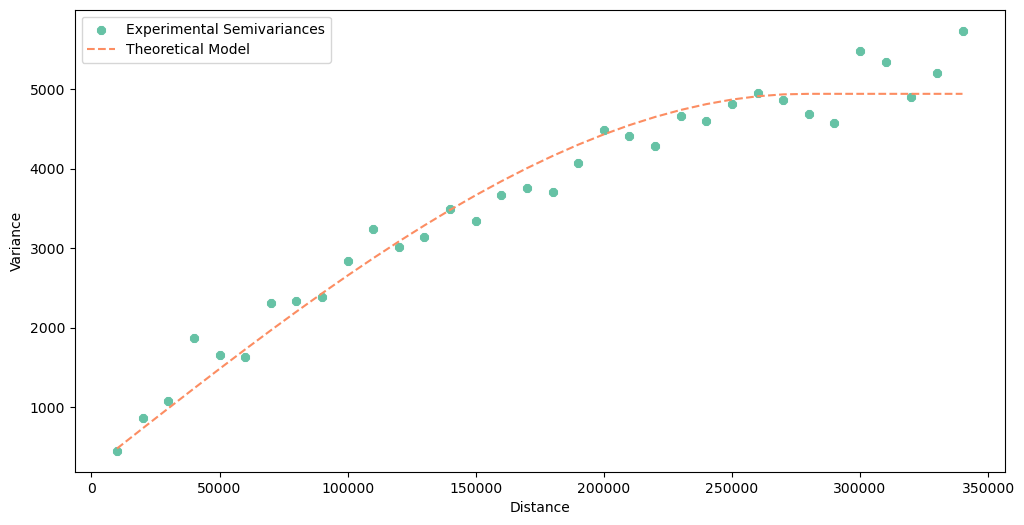

In [37]:
theor_semivar = TheoreticalVariogram()
theor_semivar.autofit(experimental_variogram=exp_semivar)
print (theor_semivar)
theor_semivar.plot()

**Question 7. Produce a krigging output with Oridinary Krigging method. Plot the output along with variance errors.**

In [38]:
predictions = kriging(observations=known_points, theoretical_model=theor_semivar, points=unknown_points, how="ok")

100%|██████████| 8732/8732 [00:02<00:00, 3485.31it/s]


In [39]:
grid["dem-pred-ok-krigging"] = predictions[:, 0]
grid["varience-error-ok-krigging"] = predictions[:, 1]

Text(0.5, 1.0, 'Ordinary Krigging Variance Error')

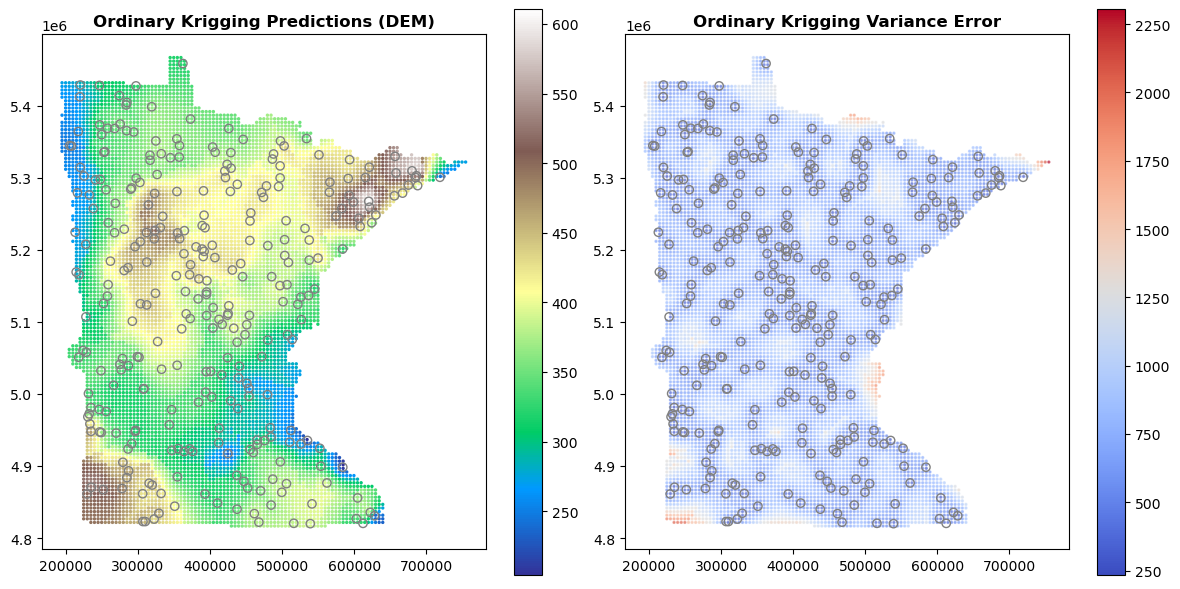

In [40]:
fig, axs = plt.subplots(1,2, figsize=(12,6), tight_layout=True)

grid.plot(ax=axs[0], column="dem-pred-ok-krigging", cmap="terrain", legend=True, markersize=2)
samples.plot(ax=axs[0], edgecolor="grey", facecolor="none")
axs[0].set_title("Ordinary Krigging Predictions (DEM)", weight="bold")

grid.plot(ax=axs[1], column="varience-error-ok-krigging", cmap="coolwarm", legend=True, markersize=2, alpha=0.5)
samples.plot(ax=axs[1], edgecolor="grey", facecolor="none")
axs[1].set_title("Ordinary Krigging Variance Error", weight="bold")

## Additional Resources

**Alternative Python libraries:**
- https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/index.html
- https://unidata.github.io/MetPy/latest/index.html
